<a href="https://colab.research.google.com/github/bigholdlu/Stock_Prediction_Sentiment_Analysis/blob/main/DJIA_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U watermark
!pip install transformers==3
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from collections import defaultdict
from tqdm.notebook import tqdm
from torch import nn
from transformers import BertModel
from sklearn.metrics import classification_report

First we load news headers and Price data, take a look how looks like, both dataset are time stamped. Also time are not synced.

In [45]:
dataset = pd.read_csv('Data.csv', parse_dates=['Time'])
djia = pd.read_csv('DJIA.csv', parse_dates=['Date'])
print(dataset.head())
print(djia.head())

        Time                                          Headlines
0 2017-12-17  The Guardian view on Ryanair’s model: a union-...
1 2017-12-17  Britons set new gin record after buying 47m bo...
2 2017-12-17  Unilever sells household name spreads to KKR f...
3 2017-12-17  Cryptocurrencies: City watchdog to investigate...
4 2017-12-17     Poundland suppliers hit by insurance downgrade
        Date      Open      High       Low     Close
0 2021-05-14  34050.86  34454.05  34050.86  34382.13
1 2021-05-13  33624.74  34181.77  33623.49  34021.45
2 2021-05-12  34206.40  34207.87  33555.22  33587.66
3 2021-05-11  34572.74  34572.74  34075.31  34269.16
4 2021-05-10  34785.27  35091.56  34741.57  34742.82


Then, we want to convert daily open close prices of DJIA into three classes by calculating the daily change.

In [46]:
djia['Diff']= djia['Open'] / djia['Close']
djia = djia[['Date','Diff']]

hi_limit = 1.007
lo_limit = 0.993
djia['Diff'][(djia['Diff'] < hi_limit) & (djia['Diff'] > lo_limit)] = 1
djia['Diff'][djia['Diff'] >= hi_limit] = 2
djia['Diff'][(djia['Diff'] < lo_limit) & (djia['Diff'] > 0)] = 0

print(djia)

           Date  Diff
0    2021-05-14   0.0
1    2021-05-13   0.0
2    2021-05-12   2.0
3    2021-05-11   2.0
4    2021-05-10   1.0
...         ...   ...
1570 2015-02-23   1.0
1571 2015-02-20   0.0
1572 2015-02-19   1.0
1573 2015-02-18   1.0
1574 2015-02-17   1.0

[1575 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Sync the news headlines with price labels by joining them using timestamp

In [47]:
news_time = dataset[['Time']].groupby('Time').first()
price_time = djia[['Date']]
common_time = pd.merge(left=news_time, right=price_time, left_on='Time',right_on='Date')


common_dataset_ = pd.merge(left=common_time, right=dataset, left_on='Date', right_on='Time').drop(labels='Time', axis=1)
common_label_ = pd.merge(left=common_time, right=djia, left_on='Date', right_on='Date')
common_label = np.array(common_label_.drop(labels='Date', axis=1))

cd = common_dataset_.groupby('Date')
common_dataset = []
for i in cd:
  common_dataset.append(np.array(i[1]['Headlines']))

# CONFIRM SYNC
print('syncd dataset: ', cd.first(), '\nsyncd label: \n', common_label_)
print('length of syncd dataset: ', len(common_dataset), '\nlength of syncd label', len(common_label))

syncd dataset:                                                      Headlines
Date                                                         
2017-12-18  Trump EPA rule change exploits taxpayers for m...
2017-12-19  China aims to drastically cut greenhouse gas e...
2017-12-20  Marks & Spencer is first supermarket to publis...
2017-12-21  Wholesalers set to appeal after Tesco's takeov...
2017-12-22  Business live  UK car production heads for fir...
...                                                       ...
2020-07-13  Daimler talks with workers heat up, with 15,00...
2020-07-14  Free pizza and a 75-foot statue of Musk: the b...
2020-07-15    J.C. Penney to cut 1,000 jobs, close 152 stores
2020-07-16  IMF chief warns global economy 'not out of the...
2020-07-17  Stripe wins business following Wirecard's coll...

[646 rows x 1 columns] 
syncd label: 
           Date  Diff
0   2017-12-18   1.0
1   2017-12-19   1.0
2   2017-12-20   1.0
3   2017-12-21   1.0
4   2017-12-22   1.0
..         .

Now data and label have same time frame. Next we want to check distribution of classes

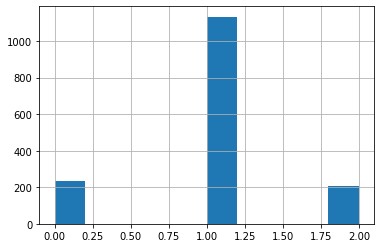

In [48]:
djia['Diff'].hist()

Clearly a imbalance in labels. The middle class has way more weight. Therefore, let's down sample the middle class and up sample other classes to makes it mode balanced

Class distribution after upsampling and down sampling


(array([15320.,     0.,     0.,     0.,     0., 14637.,     0.,     0.,
            0., 15676.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

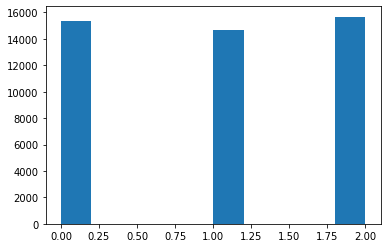

In [2]:
# Prepare a 1d dataset and label namely, single_data, single_label
data_list = []
label_list = []
for i in range(0, len(common_dataset)):
    for j in range(0, len(common_dataset[i])):
        if common_label[i] != 1:
            data_list.append(common_dataset[i][j])
            label_list.append(common_label[i])
            data_list.append(common_dataset[i][j])
            label_list.append(common_label[i])
        else:
            if j%2 == 0:
                data_list.append(common_dataset[i][j])
                label_list.append(common_label[i])

single_data = np.array(data_list)
single_label = np.array(label_list).reshape(-1,)
print('Class distribution after upsampling and down sampling')
plt.hist(single_label)

Now our dataset are well balanced and synchronized, let's tokenize them and build the dataset with tokenizer

In [3]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

encoding = tokenizer.encode_plus(
  common_dataset[0][0],
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

# BUILD DATASET

import torch
from torch.utils.data import Dataset, DataLoader

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Next step is to split the dataset into three part, train, test and validation with 0.8, 0.1, 0.1 ratio. 

In [ ]:
# train test split

t_X, val_X, t_Y, val_Y = train_test_split(single_data, single_label, test_size = 0.1)
train_X, test_X, train_Y, test_Y = train_test_split(t_X, t_Y, test_size = 0.1)

Then create dataloader for all three dataset, 

In [50]:
# Create a dataloader

def create_data_loader(data, labels, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(reviews=data, targets=labels, tokenizer = tokenizer, max_len = max_len)
    return DataLoader(ds, batch_size = batch_size, num_workers=2)

BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader(data=train_X, labels=train_Y, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
test_data_loader = create_data_loader(data=test_X, labels=test_Y, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
val_data_loader = create_data_loader(data=val_X, labels=val_Y, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)

print('trainloader shape: ', len(train_data_loader))
print('testloader shape: ', len(test_data_loader))
print('validationloader shape: ', len(val_data_loader))

trainloader shape:  2311
testloader shape:  257
validationloader shape:  286


Let's build the BERT model and evaluate a single input without training

In [5]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

class BERT_MODEL(nn.Module):

  def __init__(self, n_classes):
    super(BERT_MODEL, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

device = torch.device('cuda')
BERT_model = BERT_MODEL(n_classes=3).to(device)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
import torch.nn.functional as F
F.softmax(BERT_model(input_ids, attention_mask), dim=1)

tensor([[0.3232, 0.2811, 0.3957],
        [0.5792, 0.1748, 0.2461],
        [0.3439, 0.3679, 0.2882],
        [0.4300, 0.2800, 0.2899],
        [0.5545, 0.2293, 0.2162],
        [0.3677, 0.3430, 0.2893],
        [0.3472, 0.2443, 0.4085],
        [0.4931, 0.2210, 0.2860],
        [0.4482, 0.1958, 0.3560],
        [0.3932, 0.2789, 0.3279],
        [0.3459, 0.3288, 0.3253],
        [0.2672, 0.1467, 0.5861],
        [0.3923, 0.2847, 0.3230],
        [0.3694, 0.3206, 0.3100],
        [0.3450, 0.2241, 0.4309],
        [0.3906, 0.2741, 0.3353]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Define the loss function

In [ ]:
EPOCHS = 15
optimizer = optim.AdamW(BERT_model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

A function that train the model

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  # Switch to train model
  model = model.train()
  # Initialize history of loss, correct prediction and total predicted
  losses = []
  correct_predictions = 0
  total = 0
  
  # Iterate through the dataloader
  for d in tqdm(data_loader):
    
    # get data, attention mask and label and push into cuda
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    # perform a forward propagation
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # take the index of with highest probability
    _, preds = torch.max(outputs, dim=1)

    # calculate loss between predicted class and true class
    loss = loss_fn(outputs.cpu(), targets.cpu())

    # count result
    correct = int((targets == preds).sum().cpu())
    correct_predictions = correct_predictions + correct
    total = total + len(targets)
    losses.append(loss.item())

    # backward propagation
    loss.backward()

    # update parameters of the model
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    # zero grad the optimizer for next iteration
    optimizer.zero_grad()

    # calculate accuracy of prediction
    accuracy = correct_predictions / total

    # calculate average loss
    loss = np.mean(losses)   

  return accuracy, loss

In [6]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  # switch to evaluation mode
  model = model.eval()

  # initialize counts
  losses = []
  correct_predictions = 0
  total = 0
  y_actual = []
  y_predict = []
  
  # iterate dataloader
  for d in tqdm(data_loader):

    # get data, label and attention mask
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    # perform a forward propagation
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # take the index of with highest probability
    _, preds = torch.max(outputs, dim=1)
    
    # add predicted value to list
    y_actual.extend(targets.tolist())
    y_predict.extend(preds.tolist())

    # calculate and save loss
    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    # count correct prediction
    correct = int((targets == preds).sum().cpu())
    correct_predictions = correct_predictions + correct
    total = total + len(targets)

    # calculate accuracy of prediction
    accuracy = correct_predictions / total

    # calculate average loss
    loss = np.mean(losses)   

  return accuracy, loss, y_actual, y_predict

Train and evaluate for 15 epochs

In [7]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  #train the model
  train_output = train_epoch(model=BERT_model,
                                      data_loader=train_data_loader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device,
                                      scheduler=scheduler,
                                      n_examples=len(train_data_loader))
  #validate the model
  eval_output = eval_model(model=BERT_model,
                           data_loader=test_data_loader,
                           loss_fn=loss_fn,
                           device=device,
                           n_examples=len(test_data_loader))
  

  train_acc, train_loss = train_output[0], train_output[1]
  print('\n n_example: ', len(train_data_loader))
  print(f'Train loss {train_loss} accuracy {train_acc}')


  val_acc, val_loss =eval_output[0], eval_output[1]

  print('\n n_example: ', len(test_data_loader))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


# save the model
torch.save(BERT_model.state_dict(), 'BERT_MODEL.bin')


Epoch 1/15
----------




 n_example:  2311
Train loss 1.101867173384506 accuracy 0.36434716736107353

 n_example:  257
Val   loss 1.0668658396149424 accuracy 0.4129534940345751

Epoch 2/15
----------




 n_example:  2311
Train loss 1.0051308855098442 accuracy 0.47927601320274876

 n_example:  257
Val   loss 1.0309621385563208 accuracy 0.5137570002434867

Epoch 3/15
----------




 n_example:  2311
Train loss 0.6714946291647603 accuracy 0.71045939072561

 n_example:  257
Val   loss 1.106716745906303 accuracy 0.6238130021913806

Epoch 4/15
----------




 n_example:  2311
Train loss 0.39352082860688725 accuracy 0.8510361993398625

 n_example:  257
Val   loss 1.0220922076864465 accuracy 0.6946676406135865

Epoch 5/15
----------




 n_example:  2311
Train loss 0.2631239594375027 accuracy 0.9065526757210107

 n_example:  257
Val   loss 1.1432153871228579 accuracy 0.7302167031896761

Epoch 6/15
----------




 n_example:  2311
Train loss 0.2118492786505212 accuracy 0.9368811211514528

 n_example:  257
Val   loss 1.54650357636489 accuracy 0.7265644022400779

Epoch 7/15
----------




 n_example:  2311
Train loss 0.17119075847879664 accuracy 0.952112980899302

 n_example:  257
Val   loss 1.572007642687001 accuracy 0.749208668127587

Epoch 8/15
----------




 n_example:  2311
Train loss 0.13950933728284526 accuracy 0.9645581949028732

 n_example:  257
Val   loss 1.6484365522650166 accuracy 0.7438519600681763

Epoch 9/15
----------




 n_example:  2311
Train loss 0.11577534027905054 accuracy 0.9715112818570424

 n_example:  257
Val   loss 1.6441718586849625 accuracy 0.7669831994156319

Epoch 10/15
----------




 n_example:  2311
Train loss 0.08925479797736247 accuracy 0.9790595746983388

 n_example:  257
Val   loss 1.6863318921456325 accuracy 0.7720964207450693

Epoch 11/15
----------




 n_example:  2311
Train loss 0.06963238588337445 accuracy 0.9846599209999459

 n_example:  257
Val   loss 1.6610345492569618 accuracy 0.7847577307036766

Epoch 12/15
----------




 n_example:  2311
Train loss 0.0581455672158179 accuracy 0.9872030734267626

 n_example:  257
Val   loss 1.737229212827628 accuracy 0.7871925980034088

Epoch 13/15
----------




 n_example:  2311
Train loss 0.04202420339490034 accuracy 0.9908825280017315

 n_example:  257
Val   loss 1.8015338111237533 accuracy 0.7794010226442659

Epoch 14/15
----------




 n_example:  2311
Train loss 0.03234197582722744 accuracy 0.9923434879064985

 n_example:  257
Val   loss 1.9668982287170338 accuracy 0.7696615534453373

Epoch 15/15
----------




 n_example:  2311
Train loss 0.024365226038230433 accuracy 0.9947243114550078

 n_example:  257
Val   loss 2.0370324566978 accuracy 0.7662527392257122

CPU times: user 2h 50min 6s, sys: 46.8 s, total: 2h 50min 53s
Wall time: 2h 54min 58s


Plot the train and test loss along with accuracy

Text(0, 0.5, 'Loss')

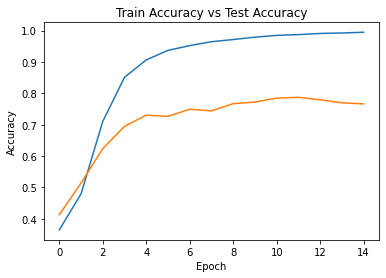

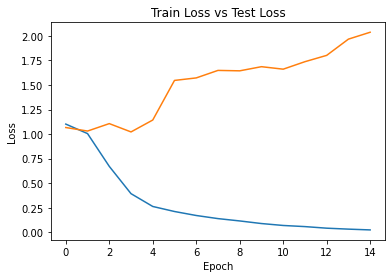

In [33]:
plt.figure()
plt.title('Train Accuracy vs Test Accuracy')
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.title('Train Loss vs Test Loss')
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [51]:
# Evaluate Model with Validation Dataset

eval_output = eval_model(model=BERT_model,
                           data_loader=val_data_loader,
                           loss_fn=loss_fn,
                           device=device,
                           n_examples=len(val_data_loader))

Showing the result on validation set with heatmap



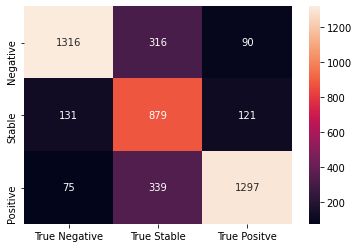

In [43]:
y_p, y_a = eval_output[2], eval_output[3]
confusion_matrix = confusion_matrix(y_a, y_p)
heatmap(confusion_matrix, annot=True, fmt='d', 
        xticklabels=['True Negative', 'True Stable', 'True Positve'],
        yticklabels=['Negative','Stable', 'Positive'], )

Finally generate a prediction result report

In [52]:
print(classification_report(y_p, y_a))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1400
           1       0.78      0.55      0.65      1369
           2       0.76      0.88      0.82      1338

    accuracy                           0.77      4107
   macro avg       0.77      0.77      0.76      4107
weighted avg       0.77      0.77      0.76      4107

